In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import io
import json
import numpy as np
import os
import pandas as pd
import pingouin as pg
from scipy import optimize, special, stats
from scipy.stats import zscore
from sklearn import linear_model
from tqdm import tqdm
import tabulate
import types
import warnings
import zipfile

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
np.set_printoptions(suppress=True)
pd.options.display.max_columns = 100
pd.options.display.max_rows    = 200
color_cycle = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255', '#AA4499']
color_map = lambda x : color_cycle[x]

In [2]:
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            try:
                yield val.__name__, val.__version__
                pass
            except:
                yield val.__name__
                pass
            pass
        pass
    pass

list(imports())

['builtins',
 'builtins',
 ('matplotlib', '3.8.2'),
 'matplotlib.pyplot',
 'io',
 ('json', '2.0.9'),
 ('numpy', '1.24.3'),
 'os',
 ('pandas', '2.1.4'),
 ('pingouin', '0.5.4'),
 'scipy.optimize',
 'scipy.special',
 'scipy.stats',
 'sklearn.linear_model',
 ('tabulate', '0.9.0'),
 'types',
 'warnings',
 'zipfile']

In [3]:
data_location = '../data/processed_data/'
dataset = pd.read_csv(data_location + 'data.csv.gz', low_memory=False)
number_duplicate_reviews = dataset.groupby('recommendation_id').size() == 60

In [4]:
print('{:,} reviews in total'.format(dataset.shape[0]//30))
print('{:,.0f} duplicates ({}%)'.format(number_duplicate_reviews.sum(), round(100*number_duplicate_reviews.mean(), 1)))
dataset = dataset.groupby('recommendation_id').filter(lambda x : x.shape[0] == 30).reset_index(drop=True)
print('{:,} reviews after excluding duplicates'.format(dataset.shape[0]//30))

3,264,943 reviews in total
183,791 duplicates (6.0%)
2,897,361 reviews after excluding duplicates


In [5]:
data_location = '../data/raw_data/'
raw_review_location = data_location + 'reviews.txt.zip'
with zipfile.ZipFile(raw_review_location) as zf:
    with io.TextIOWrapper(zf.open('reviews.txt'), encoding='utf-8') as f:
        all_reviews_raw = f.readlines()
        pass
    pass
all_reviews = [json.loads(all_reviews_raw[xxx]) for xxx in range(len(all_reviews_raw))]
mapping_reviews_reviewers = [pd.Series({xxx : yyy for xxx, yyy in zip([int(all_reviews[game_no][xyz]['recommendationid']) for xyz in range(len(all_reviews[game_no]))], [int(all_reviews[game_no][xyz]['steamid']) for xyz in range(len(all_reviews[game_no]))])}).reset_index() for game_no in range(len(all_reviews))]
mapping_reviews_reviewers = pd.concat(mapping_reviews_reviewers, axis=0)
mapping_reviews_reviewers.columns = ['recommendation_id', 'reviewer_id']
mapping_reviews_reviewers = dataset[['recommendation_id']].merge(mapping_reviews_reviewers, on='recommendation_id', how='left')
mapping_reviews_reviewers = mapping_reviews_reviewers.groupby('recommendation_id').filter(lambda x : x.shape[0] == 30).reset_index(drop=True)
mapping_reviews_reviewers = mapping_reviews_reviewers.drop_duplicates()
dataset['reviewer_id'] = dataset[['recommendation_id']].merge(mapping_reviews_reviewers, on='recommendation_id', how='left')['reviewer_id']
review_counts_per_reviewer = (dataset.groupby(['reviewer_id']).size()//30).value_counts()

In [6]:
reviews_per_reviewer = (dataset.groupby('reviewer_id').size()//30).values
print('Reviews per reviewer: M = {}, SD = {}, Mdn = {}'.format(round(np.mean(reviews_per_reviewer), 2), round(np.std(reviews_per_reviewer), 2), round(np.median(reviews_per_reviewer), 2)))
dataset_aggregated_within_reviewers = dataset.groupby(['reviewer_id', 'similarity_type', 'order'])['similarity_score'].mean().reset_index()
print('{:,} reviews from unique reviewers'.format(dataset_aggregated_within_reviewers.shape[0]//30))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    aov = pg.rm_anova(data=dataset_aggregated_within_reviewers, dv='similarity_score', within=['order', 'similarity_type'], subject='reviewer_id', effsize='np2', correction=True)
    posthoc = pg.pairwise_tests(data=dataset_aggregated_within_reviewers, dv='similarity_score', within=['similarity_type'], subject='reviewer_id', correction=True, parametric=True, effsize='cohen', padjust='holm')
    pass
pg.print_table(aov)
pg.print_table(posthoc)
dataset_aggregated_within_reviewers.groupby('similarity_type').apply(lambda x : (print(x['similarity_type'].unique()[0]), pg.print_table(pg.rm_anova(data=x, dv='similarity_score', within='order', subject='reviewer_id', effsize='np2', correction=True))));

Reviews per reviewer: M = 1.52, SD = 1.61, Mdn = 1.0
1,895,940 reviews from unique reviewers

ANOVA SUMMARY

Source                          SS    ddof1     ddof2        MS           F    p-unc    p-GG-corr    np2    eps
-----------------------  ---------  -------  --------  --------  ----------  -------  -----------  -----  -----
order                       88.425        9  17063451     9.825     433.826    0.000        0.000  0.000  0.999
similarity_type          10135.531        2   3791878  5067.765  169564.106    0.000        0.000  0.082  0.976
order * similarity_type    162.004       18  34126902     9.000     397.298    0.000        0.000  0.000  0.971


POST HOC TESTS

Contrast         A         B         Paired    Parametric           T          dof  alternative      p-unc    p-corr  p-adjust       BF10    cohen
---------------  --------  --------  --------  ------------  --------  -----------  -------------  -------  --------  ----------  -------  -------
similarity_type  co

In [7]:
%%time
plot_by_game = False
plot_colors = np.array([np.array([30,75,137, 255])/255, [0.    , 0.1262, 0.3015, 1.    ], [0.4456, 0.4477, 0.4547, 1.    ], [0.9082, 0.8219, 0.3474, 1.    ]])
descriptives = {}
regression = linear_model.LinearRegression()
for game_id in dataset['game_id'].unique():
    data = dataset[dataset['game_id'] == game_id].copy()
    by_order = data.groupby('order')['similarity_score'].mean()
    by_type = data.groupby('similarity_type')['similarity_score'].mean()
    by_both = data.groupby(['similarity_type', 'order'])['similarity_score'].mean()
    means = {'mean main bar' : by_type['main bar'], 'mean sidebar' : by_type['sidebar'], 'mean control' : by_type['control']}
    slopes = by_both.groupby('similarity_type').apply(lambda xxx : regression.fit(X=np.arange(len(xxx))[:, None], y=xxx.values).coef_[0]).rename({'main bar' : 'slope main bar', 'sidebar' : 'slope sidebar', 'control' : 'slope control'}).to_dict()
    temp_line = means | slopes
    descriptives[game_id] = temp_line
    if plot_by_game:
        f, axarr = plt.subplots(1, 1, figsize = (20, 14), gridspec_kw={'wspace' : 0.2, 'hspace' : 0.05})
        f.patch.set_alpha(0)
        axarr.plot(by_both.get('main bar').index+1, by_both.get('main bar').values, color=plot_colors[0], lw=10, label='Main bar')
        axarr.plot(by_both.get('sidebar').index+1, by_both.get('sidebar').values,   color=plot_colors[3], lw=10, label='Side bar')
        axarr.plot(by_both.get('control').index+1, by_both.get('control').values,   color=plot_colors[2], lw=10, label='Control')
        xticks = np.arange(1, 11)
        xticklabels = [r'\fontfamily{ptm}\selectfont{%d}' % xxx for xxx in xticks]
        axarr.set_xlabel(r'\fontfamily{ptm}\selectfont{Order (top to bottom)}', fontsize=50, labelpad=25)
        axarr.set_ylabel(r'\fontfamily{ptm}\selectfont{Similarity difference to reference}', fontsize=50, labelpad=25)
        max_val = by_both.max()
        min_val = by_both.min()
        lim_diff = 0.05 * (max_val-min_val)
        yticks_range = round(min_val-lim_diff, 2), round(max_val+lim_diff, 2)
        yticks = np.arange(yticks_range[0], yticks_range[1], .05)
        yticklabels = [r'\fontfamily{ptm}\selectfont{%s%s}' % ('-' if xx < 0 else '', str(abs(xx))[1:]) for xx in yticks.round(2)]
        axarr.set_xticks(xticks)
        axarr.set_xticklabels(xticklabels, fontsize=50, ha='center')
        axarr.set_yticks(yticks)
        axarr.set_yticklabels(yticklabels, fontsize=50)
        axarr.tick_params(length=10, direction='out', width=5, pad=10, labelsize=50)   
        axarr.set_ylim(min_val-lim_diff, max_val+lim_diff)
        axarr.set_xlim(min(xticks)-0.5, max(xticks)+0.5)
        axarr.axhline(0, lw=5, color='0')
        [axarr.spines[i].set_linewidth(5) for i in axarr.spines.keys()]
        axarr.spines['right'].set_visible(False)
        axarr.spines['top'].set_visible(False)
        axarr.xaxis.set_ticks_position('bottom')
        axarr.yaxis.set_ticks_position('left')
        axarr.legend(bbox_to_anchor=(.95, .3), frameon=False, loc=1, borderaxespad=0, fontsize=50)
        axarr.text(x=1, y=1, s=r'\fontfamily{ptm}\selectfont{N = %s reviews}' % data['recommendation_id'].nunique(), transform=axarr.transAxes, ha='right', va='top', fontsize=60)
        plt.savefig('../figures/by_game/{}.pdf'.format(game_id), bbox_inches='tight')
        plt.close()
        pass
    pass
descriptives = pd.DataFrame(descriptives).T
descriptives['N_reviews'] = dataset.groupby('game_id').size()

CPU times: user 23min 56s, sys: 8.43 s, total: 24min 4s
Wall time: 24min 13s


In [8]:
print(f"Main bar similarity is higher than control similarity for {round((descriptives['mean main bar'] > descriptives['mean control']).mean() * 100, 1)}% of games.")
print(f"Main bar similarity is higher than control similarity for {round((descriptives['mean main bar'] > descriptives['mean sidebar']).mean() * 100, 1)}% of games.")
print(f"Side bar similarity is higher than control similarity for {round((descriptives['mean sidebar'] > descriptives['mean control']).mean() * 100, 1)}% of games.")

Main bar similarity is higher than control similarity for 71.9% of games.
Main bar similarity is higher than control similarity for 72.0% of games.
Side bar similarity is higher than control similarity for 55.9% of games.


In [9]:
for condition in ['main bar', 'sidebar', 'control']:
    print(f"The slope of order in the {condition} is negative for {round((np.mean(descriptives[f'slope {condition}'] < 0)).mean() * 100, 1)}% of games. " 't({}) = {:.3f}, p = {:.3f}'.format(descriptives.shape[0]-1, *stats.ttest_1samp(descriptives[f'slope {condition}'], 0)))
    pass

The slope of order in the main bar is negative for 69.5% of games. t(693) = -6.840, p = 0.000
The slope of order in the sidebar is negative for 54.0% of games. t(693) = 0.308, p = 0.758
The slope of order in the control is negative for 52.3% of games. t(693) = 0.514, p = 0.607


In [10]:
only_first_mainbar = dataset.query('(similarity_type == "main bar") & (order == 1)').copy()
print('Only one similarity per review? {}'.format(only_first_mainbar['recommendation_id'].nunique() == only_first_mainbar.shape[0]))
only_first_mainbar = only_first_mainbar[['similarity_score', 'time_stampcreated', 'votes_up']].apply(zscore, axis=0).copy()
regression_model = linear_model.LinearRegression()
regression_model.fit(X=only_first_mainbar[['similarity_score', 'time_stampcreated']], y=only_first_mainbar['votes_up'])
print('Standardized regression coefficient for similarity: {:.3f}\nStandardized regression coefficient for time: {:.3f}'.format(*regression_model.coef_.round(3)))

Only one similarity per review? True
Standardized regression coefficient for similarity: 0.019
Standardized regression coefficient for time: -0.015


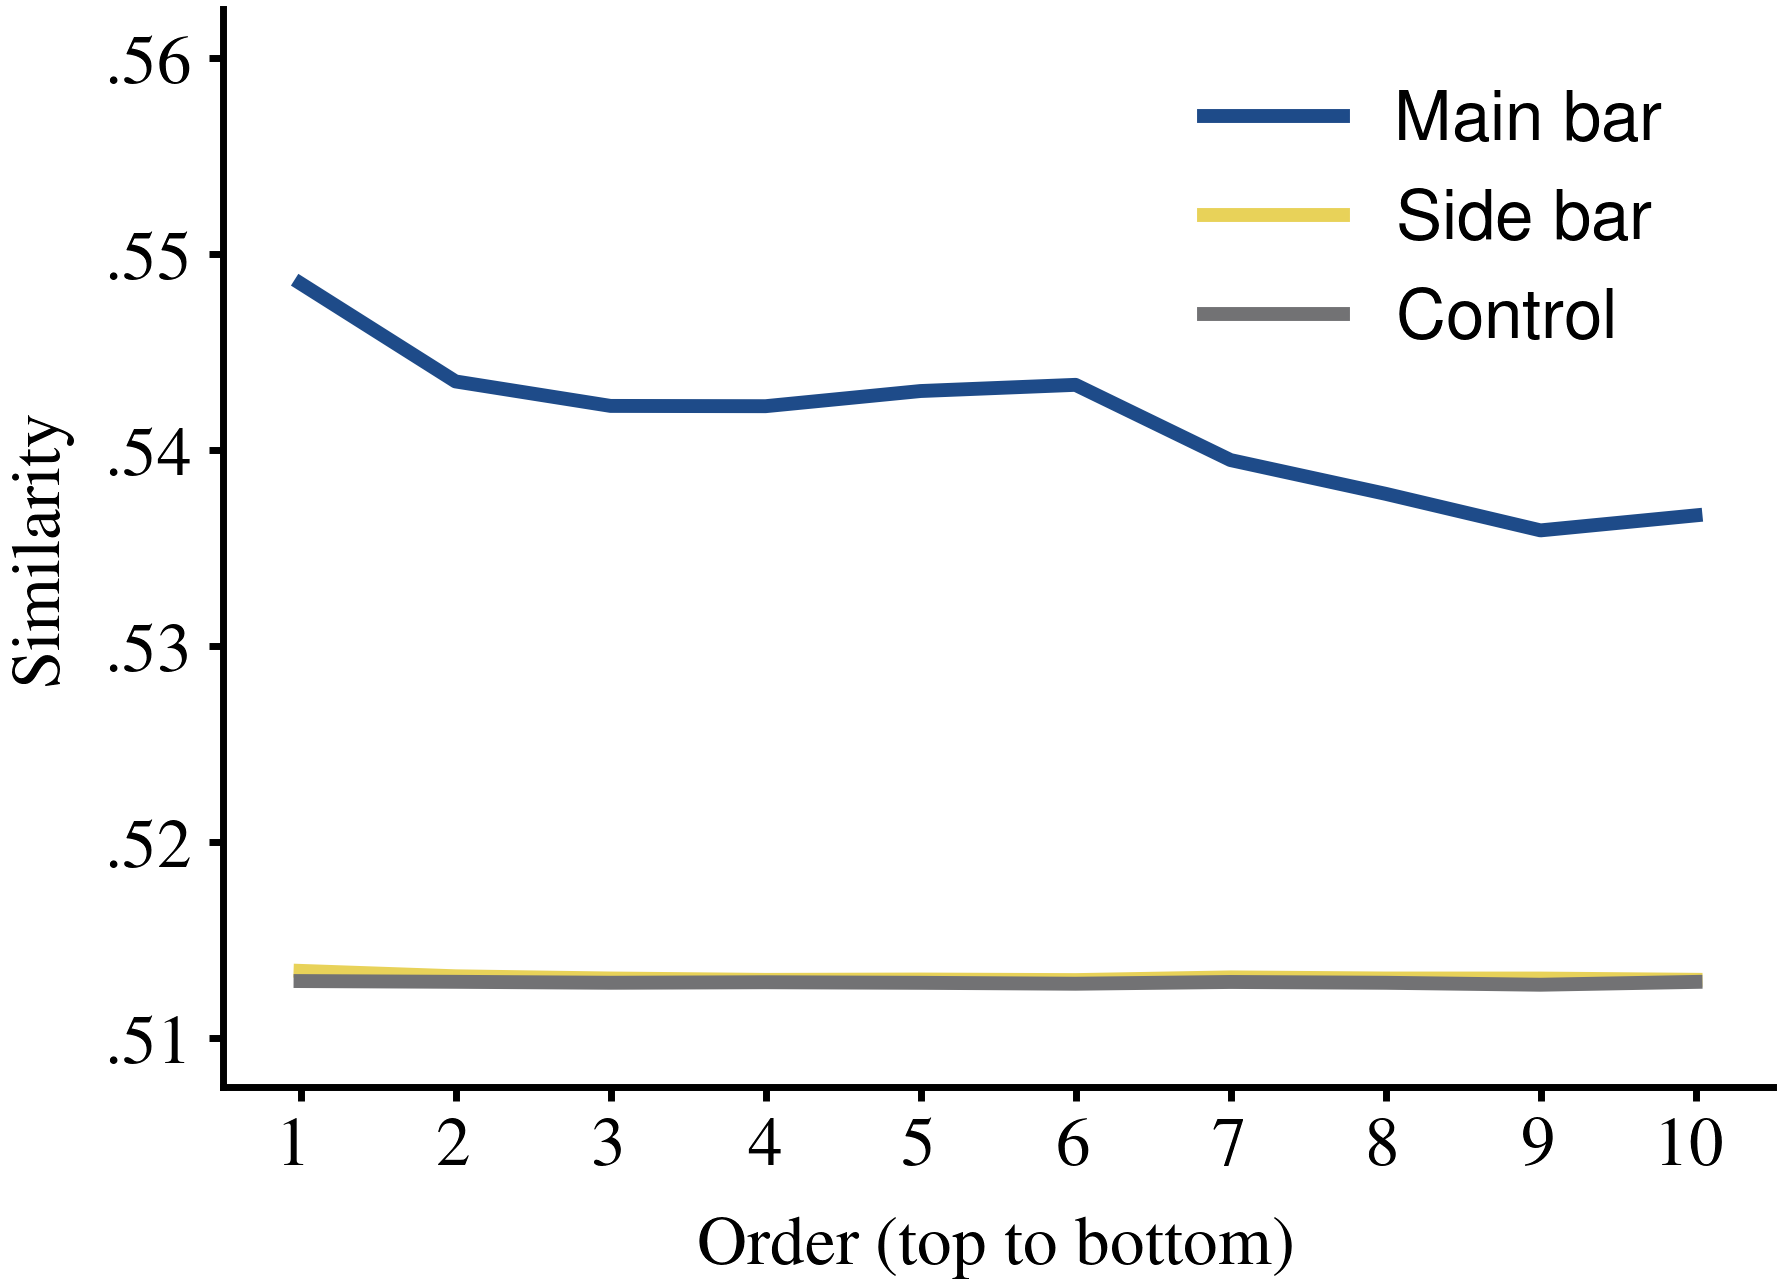

In [11]:
SE = dataset_aggregated_within_reviewers.groupby(['similarity_type', 'order'])['similarity_score'].std(ddof=1)/np.sqrt(dataset_aggregated_within_reviewers.groupby(['similarity_type', 'order'])['similarity_score'].size())
CI = stats.norm.ppf(.975) * SE

plot_colors = np.array([np.array([30,75,137, 255])/255,
                        [0.    , 0.1262, 0.3015, 1.    ],
                        [0.4456, 0.4477, 0.4547, 1.    ],
                        [0.9082, 0.8219, 0.3474, 1.    ]])

mpl.rcParams['hatch.linewidth'] = 5
mpl.rcParams['hatch.color'] = '1'
f, axarr = plt.subplots(1, 1, figsize = (20, 14), gridspec_kw={'wspace' : 0.2, 'hspace' : 0.05})
f.patch.set_alpha(0)
by_order = dataset_aggregated_within_reviewers.groupby('order')['similarity_score'].mean()
by_type = dataset_aggregated_within_reviewers.groupby('similarity_type')['similarity_score'].mean()
by_both = dataset_aggregated_within_reviewers.groupby(['similarity_type', 'order'])['similarity_score'].mean()

axarr.plot(by_both.get('main bar').index, by_both.get('main bar').values, color=plot_colors[0], lw=10, label='Main bar')
axarr.plot(by_both.get('sidebar').index, by_both.get('sidebar').values, color=plot_colors[3], lw=10, label='Side bar')
axarr.plot(by_both.get('control').index, by_both.get('control').values, color=plot_colors[2], lw=10, label='Control')

xticks = np.arange(1, 11)
xticklabels = [r'\fontfamily{ptm}\selectfont{%d}' % xxx for xxx in xticks]
yticks = np.arange(0.5, 0.6, .01)
yticklabels = [r'\fontfamily{ptm}\selectfont{%s%s}' % ('-' if xx < 0 else '', '{:.2f}'.format(abs(xx))[1:]) for xx in yticks.round(2)]

axarr.set_xlabel(r'\fontfamily{ptm}\selectfont{Order (top to bottom)}', fontsize=50, labelpad=25)
axarr.set_ylabel(r'\fontfamily{ptm}\selectfont{Similarity}', fontsize=50, labelpad=25)
axarr.set_xticks(xticks)
axarr.set_xticklabels(xticklabels, fontsize=50, ha='center')

axarr.set_yticks(yticks)
axarr.set_yticklabels(yticklabels, fontsize=50)

axarr.tick_params(length=10, direction='out', width=5, pad=10, labelsize=50)   
axarr.set_ylim(0.5075, 0.5625)
axarr.set_xlim(min(xticks)-0.5, max(xticks)+0.5)
[axarr.spines[i].set_linewidth(5) for i in axarr.spines.keys()]
axarr.spines['right'].set_visible(False)
axarr.spines['top'].set_visible(False)
axarr.xaxis.set_ticks_position('bottom')
axarr.yaxis.set_ticks_position('left')

axarr.legend(bbox_to_anchor=(.95, .95), frameon=False, loc=0, borderaxespad=0, fontsize=50)

plt.savefig('../figures/main_results.pdf', bbox_inches='tight')
plt.show()

## ANOVA without aggregating within reviewers

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    aov = pg.rm_anova(data=dataset, dv='similarity_score', within=['order', 'similarity_type'], subject='recommendation_id', effsize='np2', correction=True)
    posthoc = pg.pairwise_tests(data=dataset, dv='similarity_score', within=['similarity_type'], subject='recommendation_id', correction=True, parametric=True, effsize='cohen', padjust='holm')
    pass
pg.print_table(aov)
pg.print_table(posthoc)
dataset.groupby('similarity_type').apply(lambda x : (print(x['similarity_type'].unique()[0]), pg.print_table(pg.rm_anova(data=x, dv='similarity_score', within='order', subject='recommendation_id', effsize='np2', correction=True))));


ANOVA SUMMARY

Source                          SS    ddof1     ddof2        MS           F    p-unc    p-GG-corr    np2    eps
-----------------------  ---------  -------  --------  --------  ----------  -------  -----------  -----  -----
order                      150.813        9  26076240    16.757     639.110    0.000        0.000  0.000  0.999
similarity_type          16395.303        2   5794720  8197.651  234837.995    0.000        0.000  0.075  0.973
order * similarity_type    275.580       18  52152480    15.310     583.969    0.000        0.000  0.000  0.972


POST HOC TESTS

Contrast         A         B         Paired    Parametric           T          dof  alternative      p-unc    p-corr  p-adjust       BF10    cohen
---------------  --------  --------  --------  ------------  --------  -----------  -------------  -------  --------  ----------  -------  -------
similarity_type  control   main bar  True      True          -572.308  2897360.000  two-sided        0.000     0